# I Modeling Dataset
## - Data is generated on Data Processing Notebook 
## - Both no-split dataset and split datase are used in this notebook

# II Urbansound8K Classification
## A. RNN Classification
### - RNN Modeling
### - Load RNN split Data (data split with train and val)
### - RNN Training (train_acc at 86%, val_acc at 83% in 100 epochs )
### - Load RNN no-split Data (data split with train and val)
### - 10-Fold Cross-Validation (avg test_acc at 87%)
## B. CNN Classification
### - Load CNN split Data (data split with train and val)
### - CNN Model (VGG19) Training (train_acc at 83%, val_acc at 82.61% in 200 epochs)
### - CNN Model (VGG19) Tuning I (train_acc at 99%, val_acc at 94% in 100 epochs)
### - CNN Model (VGG19) Tuning II (train_acc at 99%, val_acc at 95%)
### - 5-Fold Cross-Validation with Tuned CNN Model (VGG19) (avg test_acc at 98%)
## C. RNN & CNN Classification
### - Load CNN split Data (data split with train and val)
### - CNN Model (VGG19) Training (train_acc at 83%, val_acc at 82.61% in 200 epochs)
### - CNN Model (VGG19) Tuning I (train_acc at 99%, val_acc at 94% in 100 epochs)
### - CNN Model (VGG19) Tuning II (train_acc at 99%, val_acc at 95%)
### - 5-Fold Cross-Validation with Tuned CNN Model (VGG19) (avg test_acc at 98%)
## D. Functional Model (CNN & RNN) Classification
### - Model Training (train_acc at 96.43%, val_acc at 93%)
### - Model Tuning I (train_acc at 98%, val_acc at 93%)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from keras import Input, optimizers, layers, models
from keras.utils import np_utils
from keras.applications import VGG19
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# early stopping
import tensorflow as tf
Callback = tf.keras.callbacks.Callback
class EarlyStoppingValAcc(Callback):
    def __init__(self, monitor='val_acc', value=0.98, verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current > self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

Using TensorFlow backend.


# RNN(GRU) Modeling

In [7]:
def rnn_model():
    ipt = Input(shape=(173,128))
    opt = layers.GRU(units = 128,dropout=0.3, recurrent_dropout=0, return_sequences=True)(ipt)
    opt = layers.BatchNormalization()(opt)
    opt = layers.GRU(units = 100,dropout=0.3, recurrent_dropout=0, return_sequences=True)(opt)
    opt = layers.BatchNormalization()(opt)
    opt = layers.GRU(units = 100,dropout=0.3, recurrent_dropout=0, return_sequences=False)(opt)
    opt = layers.BatchNormalization()(opt)
    opt = layers.Dense(128)(opt)
    opt = layers.BatchNormalization()(opt)
    opt = layers.LeakyReLU()(opt)
    opt = layers.Dense(128)(opt)
    opt = layers.BatchNormalization()(opt)
    opt = layers.LeakyReLU()(opt)
    opt = layers.Dense(64)(opt)
    opt = layers.BatchNormalization()(opt)
    opt = layers.LeakyReLU()(opt)
    opt_final= layers.Dense(10, activation='softmax')(opt)
    model = models.Model(ipt, opt_final)
    model.compile(
        optimizer= 'Adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    return model

# Load RNN data with train and validation

In [78]:
# load dataset
with open('./api_rnn_tensor','rb') as f:
    x_train, y_train, x_val, y_val = pickle.load(f)

# normalize data
def normalize_data_zScore(dt):
    for matrixIndex, matrix in enumerate(dt): 
        for rowIndex, row in enumerate(matrix):
            mean = row.mean()
            std = row.std()
            if std==0:
                std+=0.1
            dt[matrixIndex,rowIndex,:] = (row-mean)/(std)
    return dt

x_train = normalize_data_zScore(x_train)
y_train = np_utils.to_categorical(y_train, 10)
x_val = normalize_data_zScore(x_val)
y_val = np_utils.to_categorical(y_val, 10)

# RNN Model Traning

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 173, 128)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 173, 128)          98688     
_________________________________________________________________
batch_normalization_7 (Batch (None, 173, 128)          512       
_________________________________________________________________
gru_5 (GRU)                  (None, 173, 100)          68700     
_________________________________________________________________
batch_normalization_8 (Batch (None, 173, 100)          400       
_________________________________________________________________
gru_6 (GRU)                  (None, 100)               60300     
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400 

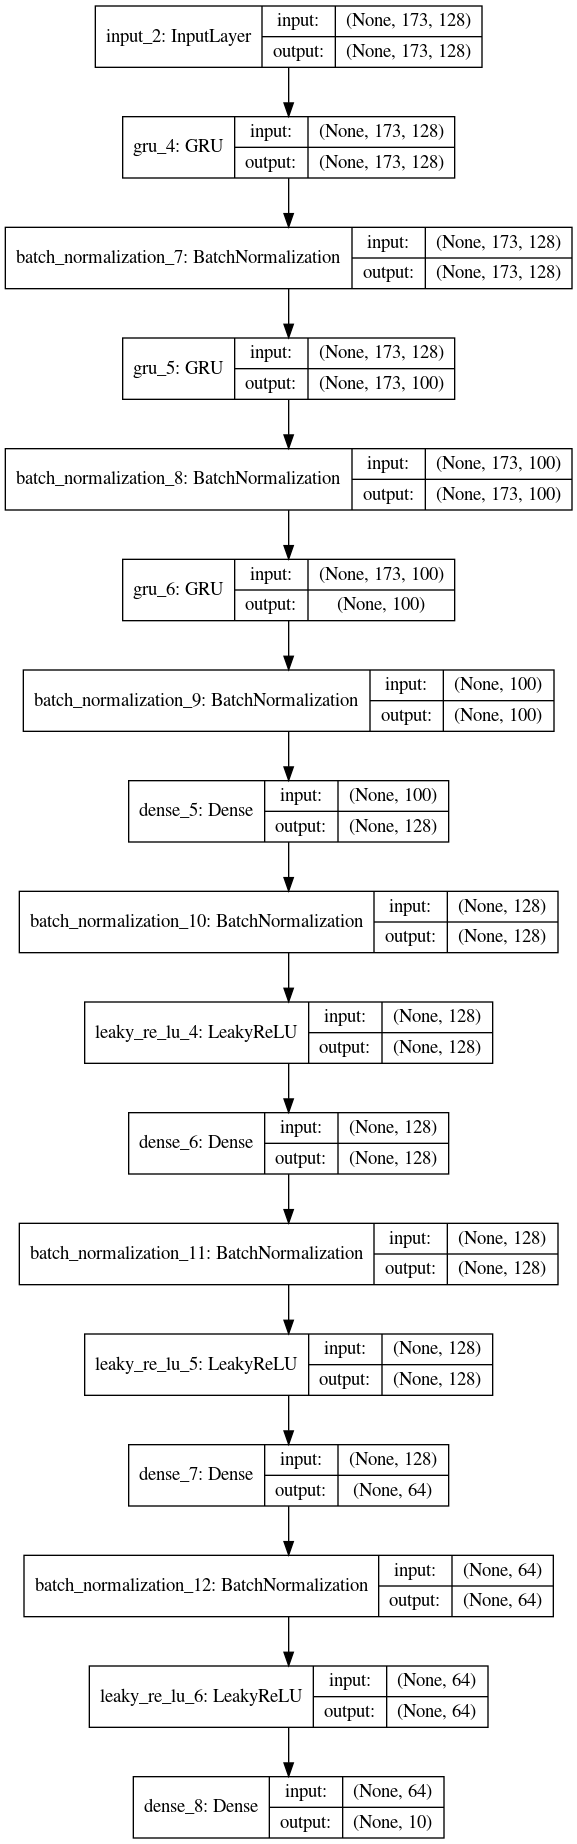

In [79]:
# build model
model = rnn_model()
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [80]:
# define callbacks
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.91, verbose=1)]

# train models
history = model.fit(
    x_train, 
    y_train,
    epochs=100,
    batch_size=128,# define early stopping class
    validation_split= 0.2,
    shuffle = True, 
    callbacks = callbacks,
)
model.evaluate(x=x_val, y=y_val, batch_size=128)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 21s 3ms/step - loss: 2.1063 - acc: 0.2595 - val_loss: 2.0394 - val_acc: 0.2881
Epoch 2/100
6400/6400 [==============================] - 19s 3ms/step - loss: 1.8075 - acc: 0.3620 - val_loss: 1.7487 - val_acc: 0.3919
Epoch 3/100
6400/6400 [==============================] - 19s 3ms/step - loss: 1.6646 - acc: 0.4208 - val_loss: 1.6099 - val_acc: 0.4412
Epoch 4/100
6400/6400 [==============================] - 20s 3ms/step - loss: 1.5661 - acc: 0.4534 - val_loss: 1.3970 - val_acc: 0.4975
Epoch 5/100
6400/6400 [==============================] - 19s 3ms/step - loss: 1.4633 - acc: 0.4933 - val_loss: 1.3869 - val_acc: 0.5106
Epoch 6/100
6400/6400 [==============================] - 19s 3ms/step - loss: 1.4144 - acc: 0.5084 - val_loss: 1.2039 - val_acc: 0.5944
Epoch 7/100
6400/6400 [==============================] - 19s 3ms/step - loss: 1.3521 - acc: 0.5353 - val_loss: 1.1647 - val_acc: 0.5894


[0.6676104046304405, 0.8126934766769409]

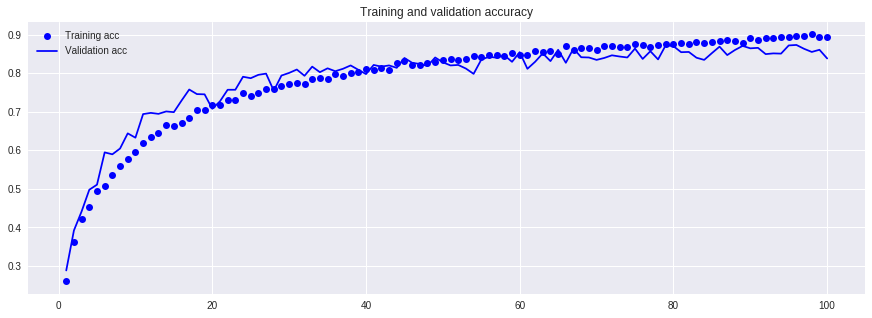

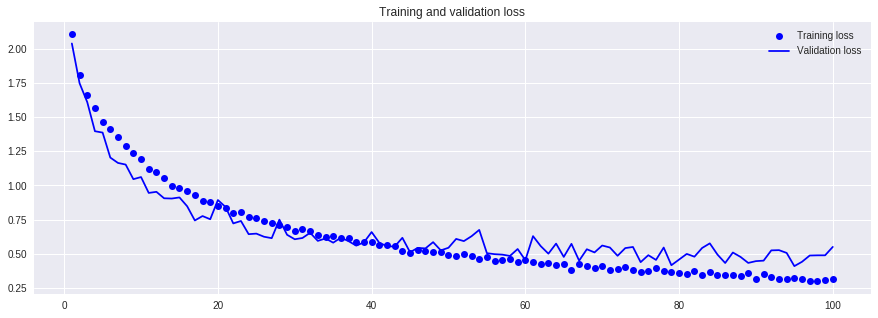

In [82]:
# plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'bo',label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [83]:
model.save('./rnn_model.h5')

# Load RNN Data (without split for train and validation)

In [4]:
# load dataset
with open('./api_rnn_tensor_nosplit','rb') as f:
    x_train, y_train= pickle.load(f)

# normalize data
def normalize_data_zScore(dt):
    for matrixIndex, matrix in enumerate(dt): 
        for rowIndex, row in enumerate(matrix):
            mean = row.mean()
            std = row.std()
            if std==0:
                std+=0.1
            dt[matrixIndex,rowIndex,:] = (row-mean)/(std)
    return dt

x_train = normalize_data_zScore(x_train)
y_train = np_utils.to_categorical(y_train, 10)

# RNN model with 10-fold Cross validation

In [9]:
# build train model process
def train_model(x_train, y_train):
    # define a model
    model = rnn_model()
    # define callbacks
    callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.91, verbose=1)]
    # train models
    history = model.fit(
        x_train, 
        y_train,
        epochs=100,
        batch_size=128,# define early stopping class
        validation_split=0.2, 
        callbacks = callbacks,
    )
    return model

In [10]:
# 10-fold cross-validation evaluation
modelEvaluation=[]
trainCount = 0
kf = KFold(n_splits=10, shuffle= True)
for train_index, test_index in kf.split(x_train):
    # count training fold
    trainCount+=1
    # clean each training session
    tf.keras.backend.clear_session()
    # generate cross-validation data
    print(f"Fold {trainCount} start! Train Data Length:", len(train_index), "Test Data Length:", len(test_index))
    fd_x_train = x_train[train_index]
    fd_y_train = y_train[train_index]
    fd_x_val = x_train[test_index]
    fd_y_val = y_train[test_index]
    # train model
    model = train_model(fd_x_train,fd_y_train)
    # evaluate model
    res = model.evaluate(fd_x_val, fd_y_val, batch_size=128)
    modelEvaluation.append(res)
    print(f'Fold {trainCount} evaluation: {res}')
    # save model
    model.save(f'./rnn_model_fold_{trainCount}.h5')        

Fold 1 start! Train Data Length: 8944 Test Data Length: 994
Train on 7155 samples, validate on 1789 samples
Epoch 1/100
7155/7155 [==============================] - 24s 3ms/step - loss: 2.0804 - acc: 0.2818 - val_loss: 2.0472 - val_acc: 0.2778
Epoch 2/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.7840 - acc: 0.3799 - val_loss: 1.7758 - val_acc: 0.3823
Epoch 3/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.6498 - acc: 0.4225 - val_loss: 1.6379 - val_acc: 0.4248
Epoch 4/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.5228 - acc: 0.4689 - val_loss: 1.3859 - val_acc: 0.5238
Epoch 5/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.4506 - acc: 0.5010 - val_loss: 1.2947 - val_acc: 0.5551
Epoch 6/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.3771 - acc: 0.5279 - val_loss: 1.2530 - val_acc: 0.5858
Epoch 7/100
7155/7155 [==============================] - 21s 3ms/step - loss

7155/7155 [==============================] - 21s 3ms/step - loss: 0.4285 - acc: 0.8580 - val_loss: 0.5158 - val_acc: 0.8379
Epoch 61/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.4313 - acc: 0.8544 - val_loss: 0.4939 - val_acc: 0.8480
Epoch 62/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.4216 - acc: 0.8565 - val_loss: 0.4929 - val_acc: 0.8474
Epoch 63/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.4048 - acc: 0.8629 - val_loss: 0.4926 - val_acc: 0.8485
Epoch 64/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.4115 - acc: 0.8593 - val_loss: 0.4992 - val_acc: 0.8452
Epoch 65/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.4136 - acc: 0.8581 - val_loss: 0.4981 - val_acc: 0.8401
Epoch 66/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3906 - acc: 0.8671 - val_loss: 0.5019 - val_acc: 0.8440
Epoch 67/100
7155/7155 [==============================

Epoch 78/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3689 - acc: 0.8755 - val_loss: 0.4677 - val_acc: 0.8625
Epoch 79/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3524 - acc: 0.8781 - val_loss: 0.4485 - val_acc: 0.8586
Epoch 80/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3525 - acc: 0.8812 - val_loss: 0.4793 - val_acc: 0.8569
Epoch 81/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3360 - acc: 0.8860 - val_loss: 0.5357 - val_acc: 0.8485
Epoch 82/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3474 - acc: 0.8861 - val_loss: 0.5015 - val_acc: 0.8463
Epoch 83/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3453 - acc: 0.8844 - val_loss: 0.5080 - val_acc: 0.8468
Epoch 84/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3463 - acc: 0.8846 - val_loss: 0.5149 - val_acc: 0.8485
Epoch 85/100
7155/7155 [=================

Epoch 96/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3077 - acc: 0.8981 - val_loss: 0.4954 - val_acc: 0.8603
Epoch 97/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3005 - acc: 0.8964 - val_loss: 0.5049 - val_acc: 0.8519
Epoch 98/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3072 - acc: 0.8941 - val_loss: 0.5332 - val_acc: 0.8530
Epoch 99/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.2935 - acc: 0.9001 - val_loss: 0.4961 - val_acc: 0.8547
Epoch 100/100
994/994 [==============================] - 1s 1ms/step
Fold 3 evaluation: [0.37332440304084563, 0.8873239159584045]
Fold 4 start! Train Data Length: 8944 Test Data Length: 994
Train on 7155 samples, validate on 1789 samples
Epoch 1/100
7155/7155 [==============================] - 23s 3ms/step - loss: 2.1143 - acc: 0.2577 - val_loss: 2.0392 - val_acc: 0.2929
Epoch 2/100
7155/7155 [==============================] - 21s 3ms/step - loss: 

7155/7155 [==============================] - 21s 3ms/step - loss: 1.0780 - acc: 0.6333 - val_loss: 0.9619 - val_acc: 0.6859
Epoch 13/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.0154 - acc: 0.6539 - val_loss: 0.8462 - val_acc: 0.7311
Epoch 14/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.9843 - acc: 0.6647 - val_loss: 1.0999 - val_acc: 0.6456
Epoch 15/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.9525 - acc: 0.6773 - val_loss: 0.8566 - val_acc: 0.7194
Epoch 16/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.9256 - acc: 0.6934 - val_loss: 0.7696 - val_acc: 0.7541
Epoch 17/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.8787 - acc: 0.7034 - val_loss: 0.7808 - val_acc: 0.7423
Epoch 18/100
7155/7155 [==============================] - 22s 3ms/step - loss: 0.8570 - acc: 0.7164 - val_loss: 0.7199 - val_acc: 0.7557
Epoch 19/100
7155/7155 [==============================

Epoch 72/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3871 - acc: 0.8734 - val_loss: 0.5241 - val_acc: 0.8424
Epoch 73/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3717 - acc: 0.8752 - val_loss: 0.5007 - val_acc: 0.8463
Epoch 74/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3698 - acc: 0.8760 - val_loss: 0.4612 - val_acc: 0.8508
Epoch 75/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3780 - acc: 0.8745 - val_loss: 0.5518 - val_acc: 0.8323
Epoch 76/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3666 - acc: 0.8808 - val_loss: 0.5024 - val_acc: 0.8586
Epoch 77/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3725 - acc: 0.8730 - val_loss: 0.5106 - val_acc: 0.8558
Epoch 78/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3739 - acc: 0.8742 - val_loss: 0.5000 - val_acc: 0.8591
Epoch 79/100
7155/7155 [=================

Epoch 90/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3194 - acc: 0.8929 - val_loss: 0.4588 - val_acc: 0.8603
Epoch 91/100
7155/7155 [==============================] - 22s 3ms/step - loss: 0.3029 - acc: 0.8935 - val_loss: 0.4189 - val_acc: 0.8815
Epoch 92/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3203 - acc: 0.8906 - val_loss: 0.3885 - val_acc: 0.8776
Epoch 93/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3042 - acc: 0.8973 - val_loss: 0.4842 - val_acc: 0.8558
Epoch 94/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3084 - acc: 0.8980 - val_loss: 0.4590 - val_acc: 0.8619
Epoch 95/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3082 - acc: 0.8957 - val_loss: 0.4599 - val_acc: 0.8647
Epoch 96/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3152 - acc: 0.8998 - val_loss: 0.4369 - val_acc: 0.8658
Epoch 97/100
7155/7155 [=================

7155/7155 [==============================] - 21s 3ms/step - loss: 1.3608 - acc: 0.5273 - val_loss: 1.1784 - val_acc: 0.6277
Epoch 7/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.3004 - acc: 0.5497 - val_loss: 1.1820 - val_acc: 0.5903
Epoch 8/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.2566 - acc: 0.5683 - val_loss: 1.0481 - val_acc: 0.6540
Epoch 9/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.1774 - acc: 0.5976 - val_loss: 1.0646 - val_acc: 0.6439
Epoch 10/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.1521 - acc: 0.6061 - val_loss: 1.0193 - val_acc: 0.6685
Epoch 11/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.0863 - acc: 0.6305 - val_loss: 0.9591 - val_acc: 0.6920
Epoch 12/100
7155/7155 [==============================] - 21s 3ms/step - loss: 1.0561 - acc: 0.6351 - val_loss: 0.9063 - val_acc: 0.7015
Epoch 13/100
7155/7155 [==============================] -

Epoch 66/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.4062 - acc: 0.8636 - val_loss: 0.4881 - val_acc: 0.8508
Epoch 67/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3817 - acc: 0.8735 - val_loss: 0.6196 - val_acc: 0.8267
Epoch 68/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3817 - acc: 0.8711 - val_loss: 0.5422 - val_acc: 0.8368
Epoch 69/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3773 - acc: 0.8732 - val_loss: 0.5203 - val_acc: 0.8491
Epoch 70/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3843 - acc: 0.8693 - val_loss: 0.5333 - val_acc: 0.8362
Epoch 71/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3660 - acc: 0.8766 - val_loss: 0.4883 - val_acc: 0.8552
Epoch 72/100
7155/7155 [==============================] - 21s 3ms/step - loss: 0.3714 - acc: 0.8753 - val_loss: 0.5106 - val_acc: 0.8468
Epoch 73/100
7155/7155 [=================

Epoch 84/100
7156/7156 [==============================] - 21s 3ms/step - loss: 0.3305 - acc: 0.8907 - val_loss: 0.4990 - val_acc: 0.8530
Epoch 85/100
7156/7156 [==============================] - 21s 3ms/step - loss: 0.3203 - acc: 0.8927 - val_loss: 0.5247 - val_acc: 0.8485
Epoch 86/100
7156/7156 [==============================] - 21s 3ms/step - loss: 0.3517 - acc: 0.8804 - val_loss: 0.4463 - val_acc: 0.8636
Epoch 87/100
7156/7156 [==============================] - 21s 3ms/step - loss: 0.3275 - acc: 0.8882 - val_loss: 0.5363 - val_acc: 0.8524
Epoch 88/100
7156/7156 [==============================] - 21s 3ms/step - loss: 0.3359 - acc: 0.8851 - val_loss: 0.4938 - val_acc: 0.8580
Epoch 89/100
7156/7156 [==============================] - 21s 3ms/step - loss: 0.3420 - acc: 0.8822 - val_loss: 0.4823 - val_acc: 0.8647
Epoch 90/100
7156/7156 [==============================] - 22s 3ms/step - loss: 0.3265 - acc: 0.8892 - val_loss: 0.4605 - val_acc: 0.8653
Epoch 91/100
7156/7156 [=================

In [20]:
print('10-fold evaluation: ')
print(*modelEvaluation, sep='\n')

10-fold evaluation: 
[0.45585903579320464, 0.8661971688270569]
[0.40125264308342273, 0.8883299827575684]
[0.37332440304084563, 0.8873239159584045]
[0.41140845759773637, 0.877263605594635]
[0.4430680586778422, 0.8692153096199036]
[0.5061482306217524, 0.8591549396514893]
[0.49186208802209774, 0.850100576877594]
[0.5139582834733084, 0.8541247248649597]
[0.4028516184287249, 0.8942598104476929]
[0.4663427388079817, 0.8731117844581604]


In [21]:
acc = [item[1] for item in modelEvaluation]
print(f'Average acc: {np.mean(acc)}')

Average acc: 0.8719081819057465


# Load CNN Data

In [4]:
# load dataset
with open('./api_cnn_tensor','rb') as f:
    cnn_x_train, cnn_y_train, cnn_x_val, cnn_y_val = pickle.load(f)

cnn_x_train = cnn_x_train/255
cnn_y_train = np_utils.to_categorical(cnn_y_train, 10)
cnn_x_val = cnn_x_val/255
cnn_y_val = np_utils.to_categorical(cnn_y_val, 10)

# CNN Model (VGG19) Training

In [5]:
vgg19_conv = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(200, 200, 3)
    )

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 200, 200, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 6, 6, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 128)               0  

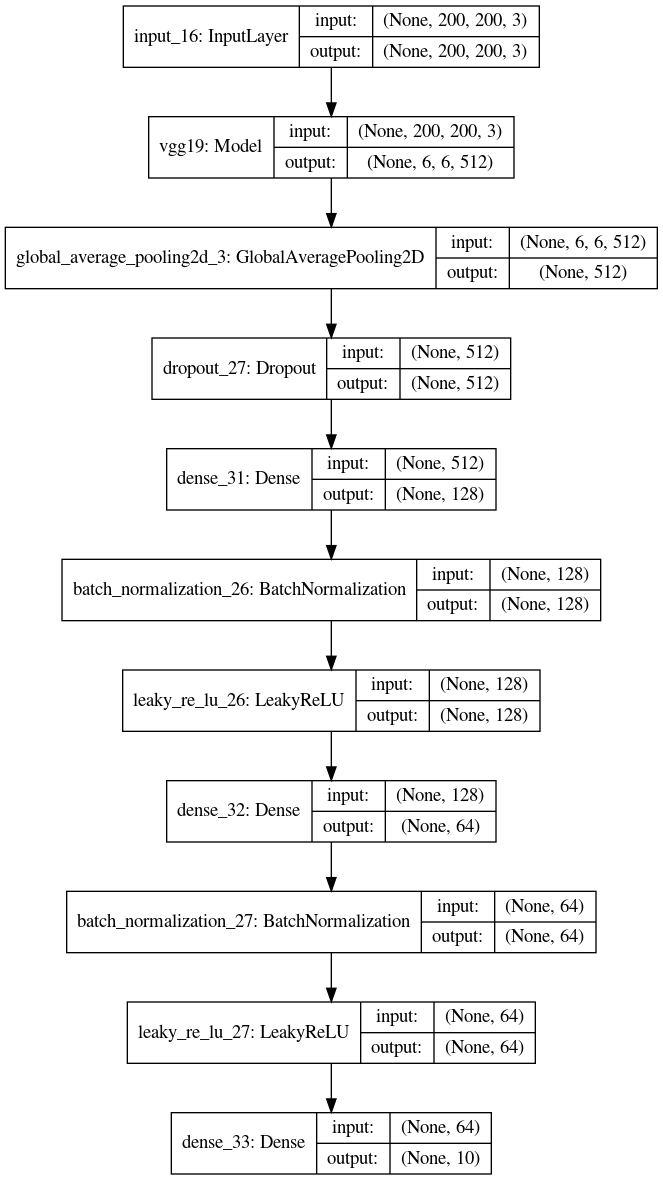

In [24]:
# build model
vgg19_conv.trainable = False
ipt = layers.Input(shape=(200,200,3))
opt = vgg19_conv(ipt)
opt = layers.GlobalAveragePooling2D()(opt)
opt = layers.Dropout(0.3)(opt)

opt = layers.Dense(128)(opt)
opt = layers.BatchNormalization()(opt)
opt = layers.LeakyReLU()(opt)

opt = layers.Dense(64)(opt)
opt = layers.BatchNormalization()(opt)
opt = layers.LeakyReLU()(opt)

opt = layers.Dense(10, activation='softmax')(opt)
model = models.Model(ipt, opt)
model.compile(
                loss='categorical_crossentropy',
                optimizer= 'Adam',
                metrics = ['acc'],)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
# define callbacks
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.90, verbose=1)]
# train the model
history = model.fit(
    cnn_x_train,
    cnn_y_train,
    epochs = 200,
    batch_size= 80,
    validation_data= (cnn_x_val,cnn_y_val),
    callbacks = callbacks,
)

Train on 8000 samples, validate on 1938 samples
Epoch 1/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.6285 - acc: 0.7807 - val_loss: 0.6262 - val_acc: 0.7921
Epoch 2/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.6195 - acc: 0.7850 - val_loss: 0.5671 - val_acc: 0.8148
Epoch 3/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.6089 - acc: 0.7901 - val_loss: 0.5865 - val_acc: 0.7967
Epoch 4/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.6111 - acc: 0.7868 - val_loss: 0.5524 - val_acc: 0.8055
Epoch 5/200
8000/8000 [==============================] - 100s 12ms/step - loss: 0.6198 - acc: 0.7836 - val_loss: 0.5694 - val_acc: 0.7915
Epoch 6/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.6117 - acc: 0.7856 - val_loss: 0.5398 - val_acc: 0.8153
Epoch 7/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.6149 - acc: 0.7829 - val_loss: 0.5460 - val_acc:

8000/8000 [==============================] - 99s 12ms/step - loss: 0.5509 - acc: 0.8055 - val_loss: 0.5073 - val_acc: 0.8302
Epoch 61/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.5589 - acc: 0.8049 - val_loss: 0.5997 - val_acc: 0.8101
Epoch 62/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.5500 - acc: 0.8085 - val_loss: 0.5305 - val_acc: 0.8194
Epoch 63/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.5544 - acc: 0.8025 - val_loss: 0.5223 - val_acc: 0.8215
Epoch 64/200
8000/8000 [==============================] - 100s 12ms/step - loss: 0.5608 - acc: 0.8049 - val_loss: 0.4963 - val_acc: 0.8338
Epoch 65/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.5436 - acc: 0.8050 - val_loss: 0.5288 - val_acc: 0.8240
Epoch 66/200
8000/8000 [==============================] - 100s 12ms/step - loss: 0.5404 - acc: 0.8089 - val_loss: 0.5622 - val_acc: 0.8194
Epoch 67/200
8000/8000 [=====================

8000/8000 [==============================] - 99s 12ms/step - loss: 0.4812 - acc: 0.8284 - val_loss: 0.4775 - val_acc: 0.8416
Epoch 179/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4748 - acc: 0.8291 - val_loss: 0.4716 - val_acc: 0.8426
Epoch 180/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4897 - acc: 0.8303 - val_loss: 0.5106 - val_acc: 0.8318
Epoch 181/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4846 - acc: 0.8309 - val_loss: 0.4955 - val_acc: 0.8277
Epoch 182/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4903 - acc: 0.8286 - val_loss: 0.5137 - val_acc: 0.8282
Epoch 183/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4740 - acc: 0.8354 - val_loss: 0.5258 - val_acc: 0.8302
Epoch 184/200
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4766 - acc: 0.8325 - val_loss: 0.4661 - val_acc: 0.8488
Epoch 185/200
8000/8000 [================

In [27]:
model.save('./cnn_model.h5')

In [30]:
res = model.evaluate(x=cnn_x_val, y=cnn_y_val, batch_size=128)

1938/1938 [==============================] - 20s 10ms/step


In [31]:
print(f'cnn_model evaluation: {res[1]}')

cnn_model evaluation: 0.8261094093322754


# CNN Model Tunning I
## Freeze dense layers and unfreeze last block of VGG19

In [9]:
model = models.load_model('./cnn_model.h5')
# print layers & model summary
layers = model.layers
for i, layer in enumerate(layers):
    if i==1:
        layer.trainable = True
        print(f'_{layer.name}: {layer.trainable}')
        for ly in layer.layers:
            if ly.name == 'block5_conv4':
                ly.trainable= True
                print(f'  {ly.name}: {ly.trainable}')
            elif ly.name == 'block5_conv3':
                ly.trainable = True
                print(f'  {ly.name}: {ly.trainable}')
            elif ly.name == 'block5_conv2':
                ly.trainable= True
                print(f'  {ly.name}: {ly.trainable}')
            elif ly.name == 'block5_conv1':
                ly.trainable = True
                print(f'  {ly.name}: {ly.trainable}')
            else:
                ly.trainable=False
                print(f'  {ly.name}: {ly.trainable}')
    else:
        layer.trainable = False
        print(f'_{layer.name}: {layer.trainable}')
# model compile
model.compile(
                loss='categorical_crossentropy',
                optimizer= 'Adam',
                metrics = ['acc'],)
model.summary()

_input_16: False
_vgg19: True
  input_1: False
  block1_conv1: False
  block1_conv2: False
  block1_pool: False
  block2_conv1: False
  block2_conv2: False
  block2_pool: False
  block3_conv1: False
  block3_conv2: False
  block3_conv3: False
  block3_conv4: False
  block3_pool: False
  block4_conv1: False
  block4_conv2: False
  block4_conv3: False
  block4_conv4: False
  block4_pool: False
  block5_conv1: True
  block5_conv2: True
  block5_conv3: True
  block5_conv4: True
  block5_pool: False
_global_average_pooling2d_3: False
_dropout_27: False
_dense_31: False
_batch_normalization_26: False
_leaky_re_lu_26: False
_dense_32: False
_batch_normalization_27: False
_leaky_re_lu_27: False
_dense_33: False
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 200, 200, 3)       0         
_________________________________________________________________
vgg19

/home/ky/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
# define callbacks
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.94, verbose=1)]
# train the model
history = model.fit(
    cnn_x_train,
    cnn_y_train,
    epochs = 100,
    batch_size= 80,
    validation_data= (cnn_x_val,cnn_y_val),
    callbacks = callbacks,
)

In [ ]:
model.save('./cnn_model_I.h5')

# CNN Model Tunning II
## freeze first 2 layers in the final block of VGG 19 and train last 2 layers of VGG19 and dense layers jointly

/home/ky/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_input_16: False
_vgg19: True
  input_1: False
  block1_conv1: False
  block1_conv2: False
  block1_pool: False
  block2_conv1: False
  block2_conv2: False
  block2_pool: False
  block3_conv1: False
  block3_conv2: False
  block3_conv3: False
  block3_conv4: False
  block3_pool: False
  block4_conv1: False
  block4_conv2: False
  block4_conv3: False
  block4_conv4: False
  block4_pool: False
  block5_conv1: True
  block5_conv2: True
  block5_conv3: True
  block5_conv4: True
  block5_pool: False
_global_average_pooling2d_3: False
_dropout_27: False
_dense_31: False
_batch_normalization_26: False
_leaky_re_lu_26: False
_dense_32: False
_batch_normalization_27: False
_leaky_re_lu_27: False
_dense_33: False
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 200, 200, 3)       0         
_________________________________________________________________
vgg19

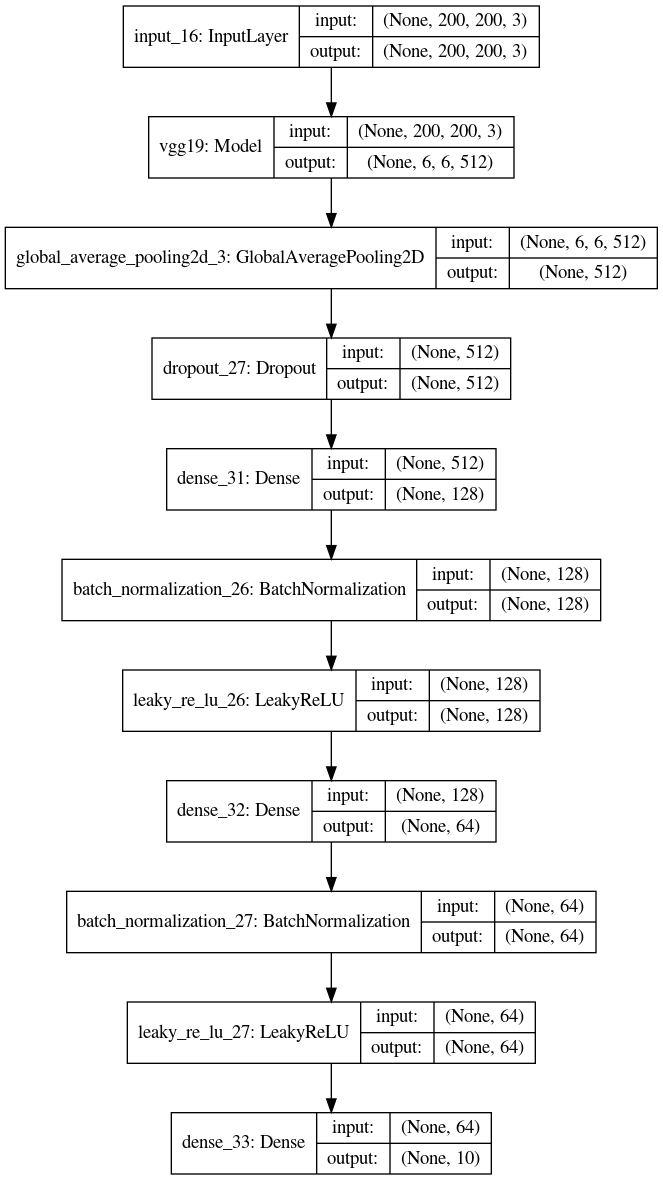

In [39]:
model = models.load_model('./cnn_model_I.h5')
# print layers & model summary
layers = model.layers
for i, layer in enumerate(layers):
    if i==1:
        layer.trainable = True
        print(f'_{layer.name}: {layer.trainable}')
        for ly in layer.layers:
            if ly.name == 'block5_conv4':
                ly.trainable= True
                print(f'  {ly.name}: {ly.trainable}')
            elif ly.name == 'block5_conv3':
                ly.trainable = True
                print(f'  {ly.name}: {ly.trainable}')
            else:
                ly.trainable=False
                print(f'  {ly.name}: {ly.trainable}')
    else:
        layer.trainable = True
        print(f'_{layer.name}: {layer.trainable}')
        
# model compile
model.compile(
                loss='categorical_crossentropy',
                optimizer= 'Adam',
                metrics = ['acc'],)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define callbacks
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.95, verbose=1)]
# train the model
history = model.fit(
    cnn_x_train,
    cnn_y_train,
    epochs = 100,
    batch_size= 80,
    validation_data= (cnn_x_val,cnn_y_val),
    callbacks = callbacks,
)

In [ ]:
model.save('./cnn_model_II.h5')

# CNN model with 5-fold Cross validation
## Retrain & evaluate dense layers of tuned model

In [3]:
import numpy as np
from sklearn.model_selection import KFold
import gc

In [4]:
# load dataset
with open('./api_cnn_tensor_nosplit','rb') as f:
    cnn_x_train, cnn_y_train = pickle.load(f)

cnn_x_train = cnn_x_train/255
cnn_y_train = np_utils.to_categorical(cnn_y_train, 10)

In [10]:
# load model and freeze layers
def get_model():
    # define a model
    model = models.load_model('./cnn_model_II.h5')
    # print layers & model summary
    layers = model.layers
    for i, layer in enumerate(layers):
        if i==1:
            layer.trainable = False
            for ly in layer.layers:
                ly.trainable=False
        else:
            layer.trainable = True
    # compile the model
    model.compile(
                loss='categorical_crossentropy',
                optimizer= 'Adam',
                metrics = ['acc'],)
    return model

# build train model process
def train_model(x_train, y_train, x_val, y_val, model):
    # define callbacks
    callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.95, verbose=1)]
    # train models
    history = model.fit(
        x_train, 
        y_train,
        epochs=100,
        batch_size=50,# define early stopping class
        validation_data=(x_val, y_val), 
        callbacks = callbacks,
    )
    return model

In [6]:
# 10-fold cross-validation evaluation
trainCount = 0
kf = KFold(n_splits=5, shuffle= True)
for train_index, test_index in kf.split(cnn_x_train):
    # clean each training session
    tf.keras.backend.clear_session()
    # count training fold
    trainCount+=1
    # print cross-validation data
    print(f"Fold {trainCount} start! Train Data Length:", len(train_index), "Test Data Length:", len(test_index))
    # train model
    model = train_model(cnn_x_train[train_index],cnn_y_train[train_index], cnn_x_train[test_index], cnn_y_train[test_index],get_model())
    # save model
    model.save(f'./cnn_model_fold_{trainCount}.h5')
    # clear unreferenced memory
    del model
    gc.collect()

Fold 1 start! Train Data Length: 7950 Test Data Length: 1988
Train on 7950 samples, validate on 1988 samples
Epoch 1/100
7950/7950 [==============================] - 120s 15ms/step - loss: 0.0641 - acc: 0.9889 - val_loss: 0.0480 - val_acc: 0.9899
Epoch 00000: early stopping THR
Fold 2 start! Train Data Length: 7950 Test Data Length: 1988
Train on 7950 samples, validate on 1988 samples
Epoch 1/100
7950/7950 [==============================] - 113s 14ms/step - loss: 0.0625 - acc: 0.9883 - val_loss: 0.0581 - val_acc: 0.9889
Epoch 00000: early stopping THR
Fold 3 start! Train Data Length: 7950 Test Data Length: 1988
Train on 7950 samples, validate on 1988 samples
Epoch 1/100
7950/7950 [==============================] - 113s 14ms/step - loss: 0.0676 - acc: 0.9873 - val_loss: 0.0440 - val_acc: 0.9920
Epoch 00000: early stopping THR
Fold 4 start! Train Data Length: 7951 Test Data Length: 1987
Train on 7951 samples, validate on 1987 samples
Epoch 1/100
7951/7951 [==============================]

# Functional model with RNN and VGG19

In [3]:
# load cnn dataset
with open('./api_cnn_tensor','rb') as f:
    cnn_x_train, cnn_y_train, cnn_x_val, cnn_y_val = pickle.load(f)

cnn_x_train = cnn_x_train/255
cnn_y_train = np_utils.to_categorical(cnn_y_train, 10)
cnn_x_val = cnn_x_val/255
cnn_y_val = np_utils.to_categorical(cnn_y_val, 10)

# load rnn dataset
with open('./api_rnn_tensor','rb') as f:
    rnn_x_train, rnn_y_train, rnn_x_val, rnn_y_val = pickle.load(f)

# normalize data
def normalize_data_zScore(dt):
    for matrixIndex, matrix in enumerate(dt): 
        for rowIndex, row in enumerate(matrix):
            mean = row.mean()
            std = row.std()
            if std==0:
                std+=0.1
            dt[matrixIndex,rowIndex,:] = (row-mean)/(std)
    return dt

rnn_x_train = normalize_data_zScore(rnn_x_train)
rnn_y_train = np_utils.to_categorical(rnn_y_train, 10)
rnn_x_val = normalize_data_zScore(rnn_x_val)
rnn_y_val = np_utils.to_categorical(rnn_y_val, 10)

In [7]:
vgg19_conv = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(200, 200, 3)
    )
vgg19_conv.trainable=False

In [8]:
def api_model():
    # define cnn part
    cnn_ipt = Input(shape=(200,200,3), name='cnn_input')
    cnn = vgg19_conv(cnn_ipt)
    cnn_sp = layers.GlobalAveragePooling2D()(cnn)
    cnn_sp = layers.Dropout(0.3)(cnn_sp)
    cnn = layers.Reshape((512,1))(cnn_sp)
    rnn = layers.GRU(units = 128, dropout=0.3, return_sequences=True)(cnn)
    rnn = layers.GRU(units = 100, dropout=0.3, return_sequences=False)(rnn)

    # define rnn part
    rnn_ipt = Input(shape=(173,128), name='rnn_input')
    rnn_2 = layers.GRU(units = 128, dropout=0.3, return_sequences=True)(rnn_ipt)
    rnn_2_opt = layers.GRU(units = 100, dropout=0.3, return_sequences=False)(rnn_2)
    rnn_2 = layers.Dense(128)(rnn_2_opt)
    rnn_2 = layers.LeakyReLU()(rnn_2)
    rnn_2 = layers.BatchNormalization()(rnn_2)

    # concatenate level 1
    concat = layers.concatenate([rnn, rnn_2], axis=-1)
    concat = layers.Dense(128)(concat)
    concat = layers.LeakyReLU()(concat)
    concat = layers.BatchNormalization()(concat)

    # concatenate level2 
    concat2 = layers.concatenate([concat, cnn_sp], axis=-1)
    concat2 = layers.Dense(256)(concat2)
    concat2 = layers.LeakyReLU()(concat2)
    concat2 = layers.BatchNormalization()(concat2)
    
    # concatenate level3
    concat3 = layers.concatenate([concat2,rnn_2_opt], axis=-1)
    concat3 = layers.Dense(256)(concat3)
    concat3 = layers.LeakyReLU()(concat3)
    concat3 = layers.BatchNormalization()(concat3)
    
    # output layer
    opt = layers.Dense(10, activation='softmax')(concat3)
    api_model = models.Model([cnn_ipt,rnn_ipt],opt)
    api_model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    return api_model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
vgg19 (Model)                   (None, 6, 6, 512)    20024384    cnn_input[0][0]                  
__________________________________________________________________________________________________
rnn_input (InputLayer)          (None, 173, 128)     0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg19[3][0]                      
____________________________________________________________________________________________

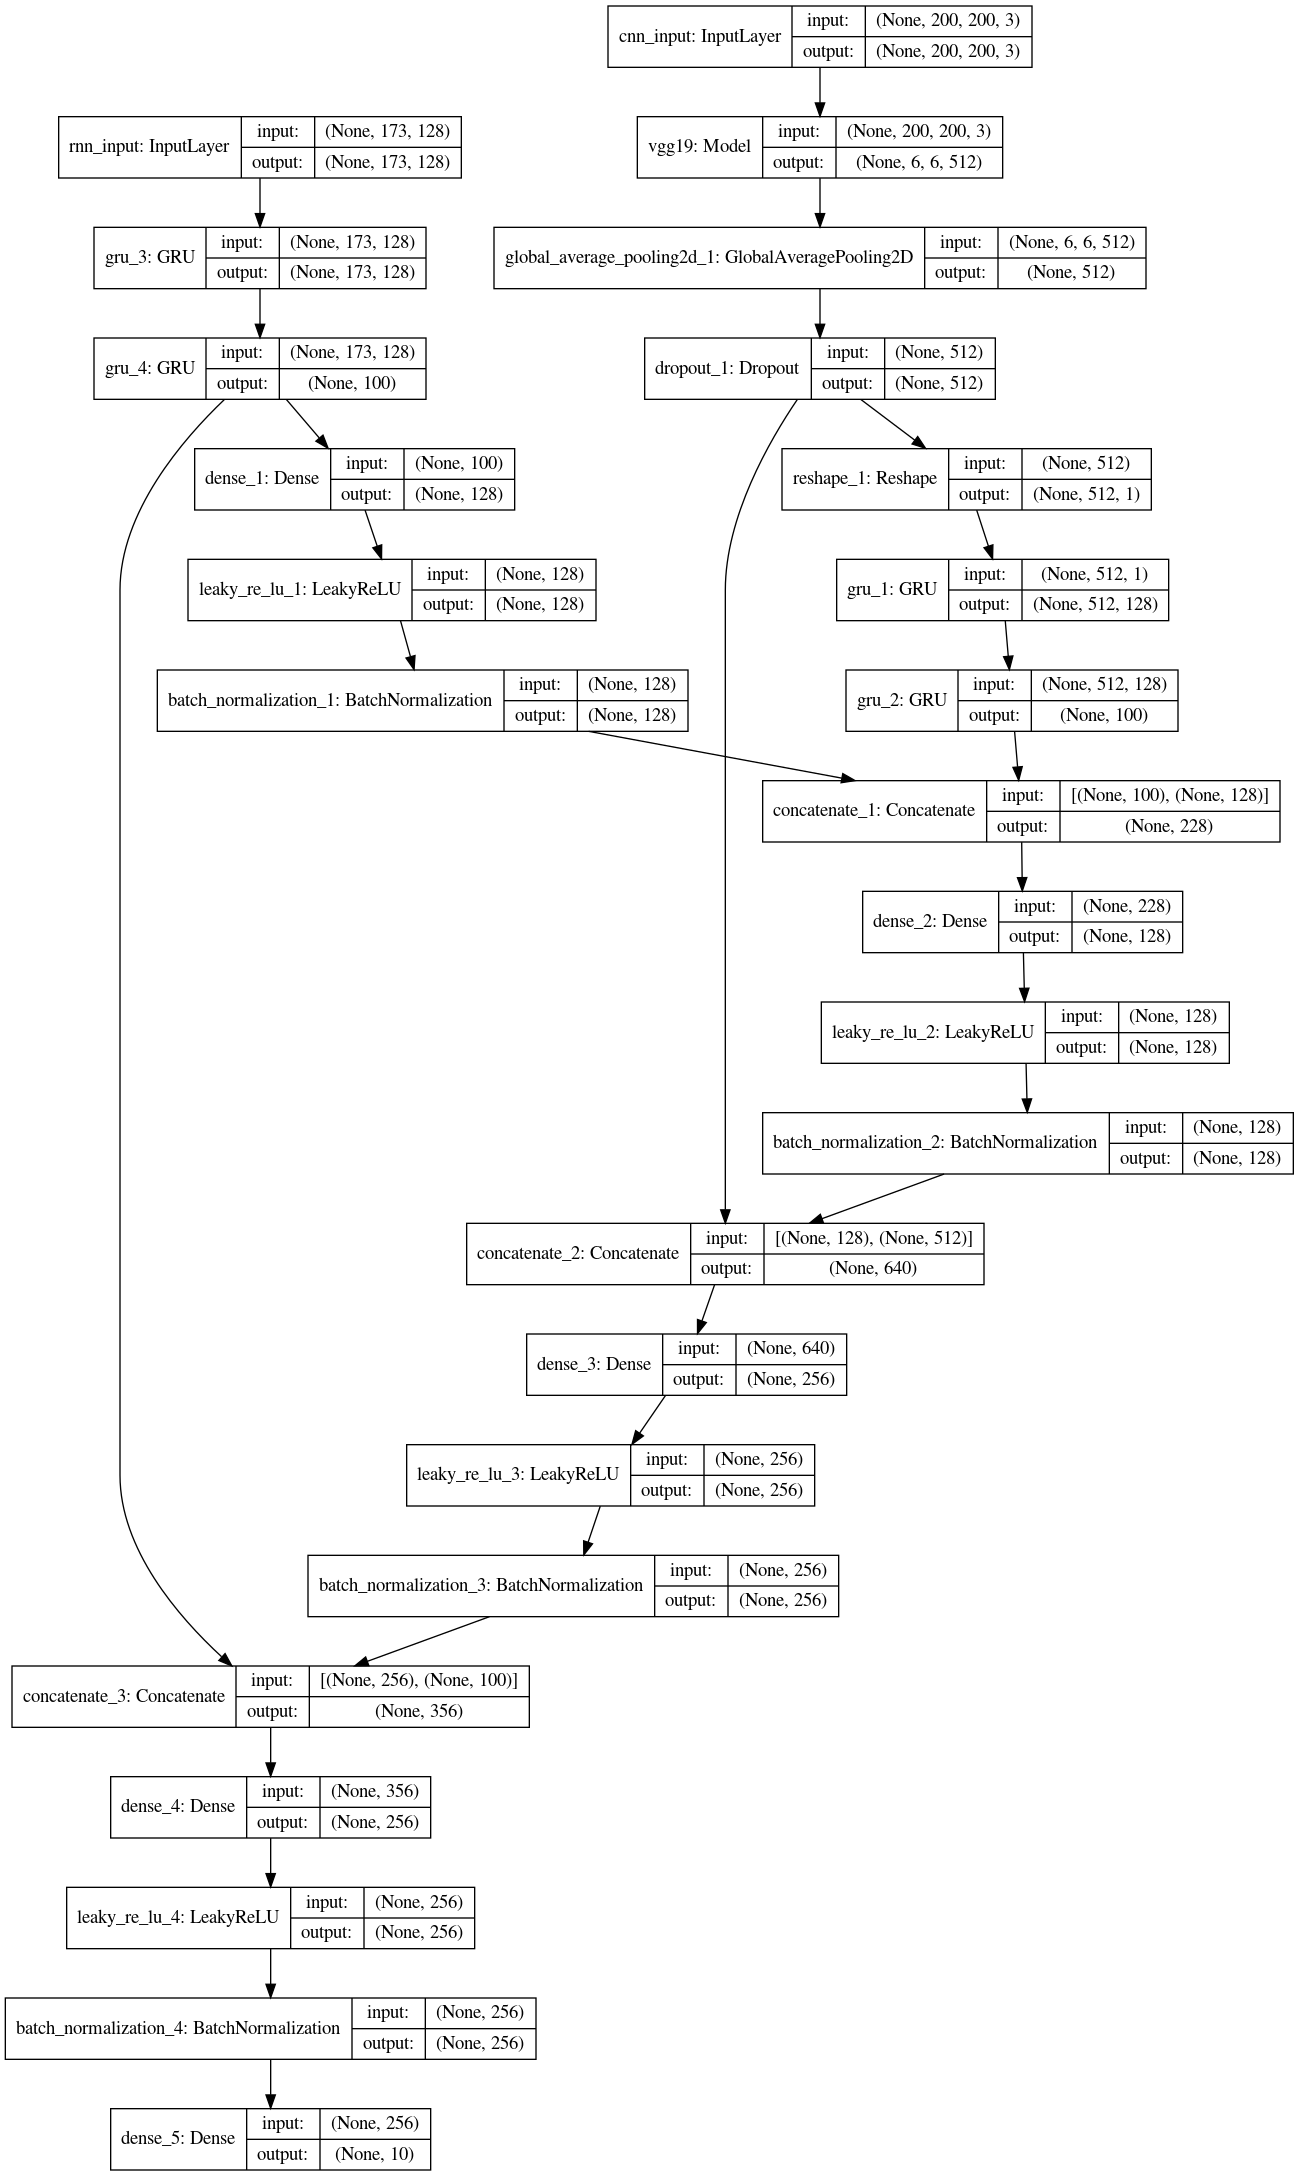

In [12]:
model = api_model()
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# train model
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.93, verbose=1)]
history = model.fit(
    x= {
        'cnn_input':cnn_x_train,
        'rnn_input':rnn_x_train,
    },
    y= cnn_y_train,
    epochs = 50,
    batch_size= 50,
    validation_data = ([cnn_x_val, rnn_x_val],cnn_y_val),
    callbacks = callbacks,
)

Train on 8000 samples, validate on 1938 samples
Epoch 1/50
8000/8000 [==============================] - 271s 34ms/step - loss: 0.1142 - acc: 0.9595 - val_loss: 0.3084 - val_acc: 0.9159
Epoch 2/50
8000/8000 [==============================] - 271s 34ms/step - loss: 0.1127 - acc: 0.9616 - val_loss: 0.3021 - val_acc: 0.9195
Epoch 3/50
8000/8000 [==============================] - 271s 34ms/step - loss: 0.1055 - acc: 0.9646 - val_loss: 0.2867 - val_acc: 0.9221
Epoch 4/50
8000/8000 [==============================] - 267s 33ms/step - loss: 0.1189 - acc: 0.9591 - val_loss: 0.3302 - val_acc: 0.9169
Epoch 5/50
8000/8000 [==============================] - 265s 33ms/step - loss: 0.1082 - acc: 0.9629 - val_loss: 0.3106 - val_acc: 0.9221
Epoch 6/50
8000/8000 [==============================] - 264s 33ms/step - loss: 0.1172 - acc: 0.9589 - val_loss: 0.3138 - val_acc: 0.9200
Epoch 7/50
8000/8000 [==============================] - 264s 33ms/step - loss: 0.1114 - acc: 0.9636 - val_loss: 0.3213 - val_acc: 

In [15]:
model.save('./api_model_I.h5')

# Functional Model Tuning I (Unfreeze final layer of VGG19 and freeze all other layers)

In [18]:
def api_model():
    # define cnn part
    cnn_ipt = Input(shape=(200,200,3), name='cnn_input')
    cnn = vgg19_conv(cnn_ipt)
    cnn_sp = layers.GlobalAveragePooling2D()(cnn)
    cnn_sp = layers.Dropout(0.5)(cnn_sp)
    cnn = layers.Reshape((512,1))(cnn_sp)
    rnn = layers.GRU(units = 128, dropout=0.3, return_sequences=True)(cnn)
    rnn = layers.GRU(units = 100, dropout=0.3, return_sequences=False)(rnn)

    # define rnn part
    rnn_ipt = Input(shape=(173,128), name='rnn_input')
    rnn_2 = layers.GRU(units = 128, dropout=0.3, return_sequences=True)(rnn_ipt)
    rnn_2_opt = layers.GRU(units = 100, dropout=0.3, return_sequences=False)(rnn_2)
    rnn_2 = layers.Dense(128)(rnn_2_opt)
    rnn_2 = layers.LeakyReLU()(rnn_2)
    rnn_2 = layers.BatchNormalization()(rnn_2)
    rnn_2 = layers.Dropout(0.3)(rnn_2)
    
    # concatenate level 1
    concat = layers.concatenate([rnn, rnn_2], axis=-1)
    concat = layers.Dense(128)(concat)
    concat = layers.LeakyReLU()(concat)
    concat = layers.BatchNormalization()(concat)
    concat = layers.Dropout(0.3)(concat)

    # concatenate level2 
    concat2 = layers.concatenate([concat, cnn_sp], axis=-1)
    concat2 = layers.Dense(256)(concat2)
    concat2 = layers.LeakyReLU()(concat2)
    concat2 = layers.BatchNormalization()(concat2)
    concat2 = layers.Dropout(0.3)(concat2)
    
    # concatenate level3
    concat3 = layers.concatenate([concat2,rnn_2_opt], axis=-1)
    concat3 = layers.Dense(256)(concat3)
    concat3 = layers.LeakyReLU()(concat3)
    concat3 = layers.BatchNormalization()(concat3)
    concat3 = layers.Dropout(0.3)(concat3)
    
    # output layer
    opt = layers.Dense(10, activation='softmax')(concat3)
    api_model = models.Model([cnn_ipt,rnn_ipt],opt)
    api_model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    return api_model

_cnn_input: True
_rnn_input: True
_vgg19: True
  input_1: False
  block1_conv1: False
  block1_conv2: False
  block1_pool: False
  block2_conv1: False
  block2_conv2: False
  block2_pool: False
  block3_conv1: False
  block3_conv2: False
  block3_conv3: False
  block3_conv4: False
  block3_pool: False
  block4_conv1: False
  block4_conv2: False
  block4_conv3: False
  block4_conv4: False
  block4_pool: False
  block5_conv1: False
  block5_conv2: False
  block5_conv3: False
  block5_conv4: True
  block5_pool: False
_gru_11: True
_global_average_pooling2d_3: True
_gru_12: True
_dropout_3: True
_dense_11: True
_reshape_3: True
_leaky_re_lu_9: True
_gru_9: True
_batch_normalization_9: True
_gru_10: True
_dropout_4: True
_concatenate_7: True
_dense_12: True
_leaky_re_lu_10: True
_batch_normalization_10: True
_dropout_5: True
_concatenate_8: True
_dense_13: True
_leaky_re_lu_11: True
_batch_normalization_11: True
_dropout_6: True
_concatenate_9: True
_dense_14: True
_leaky_re_lu_12: True
_ba

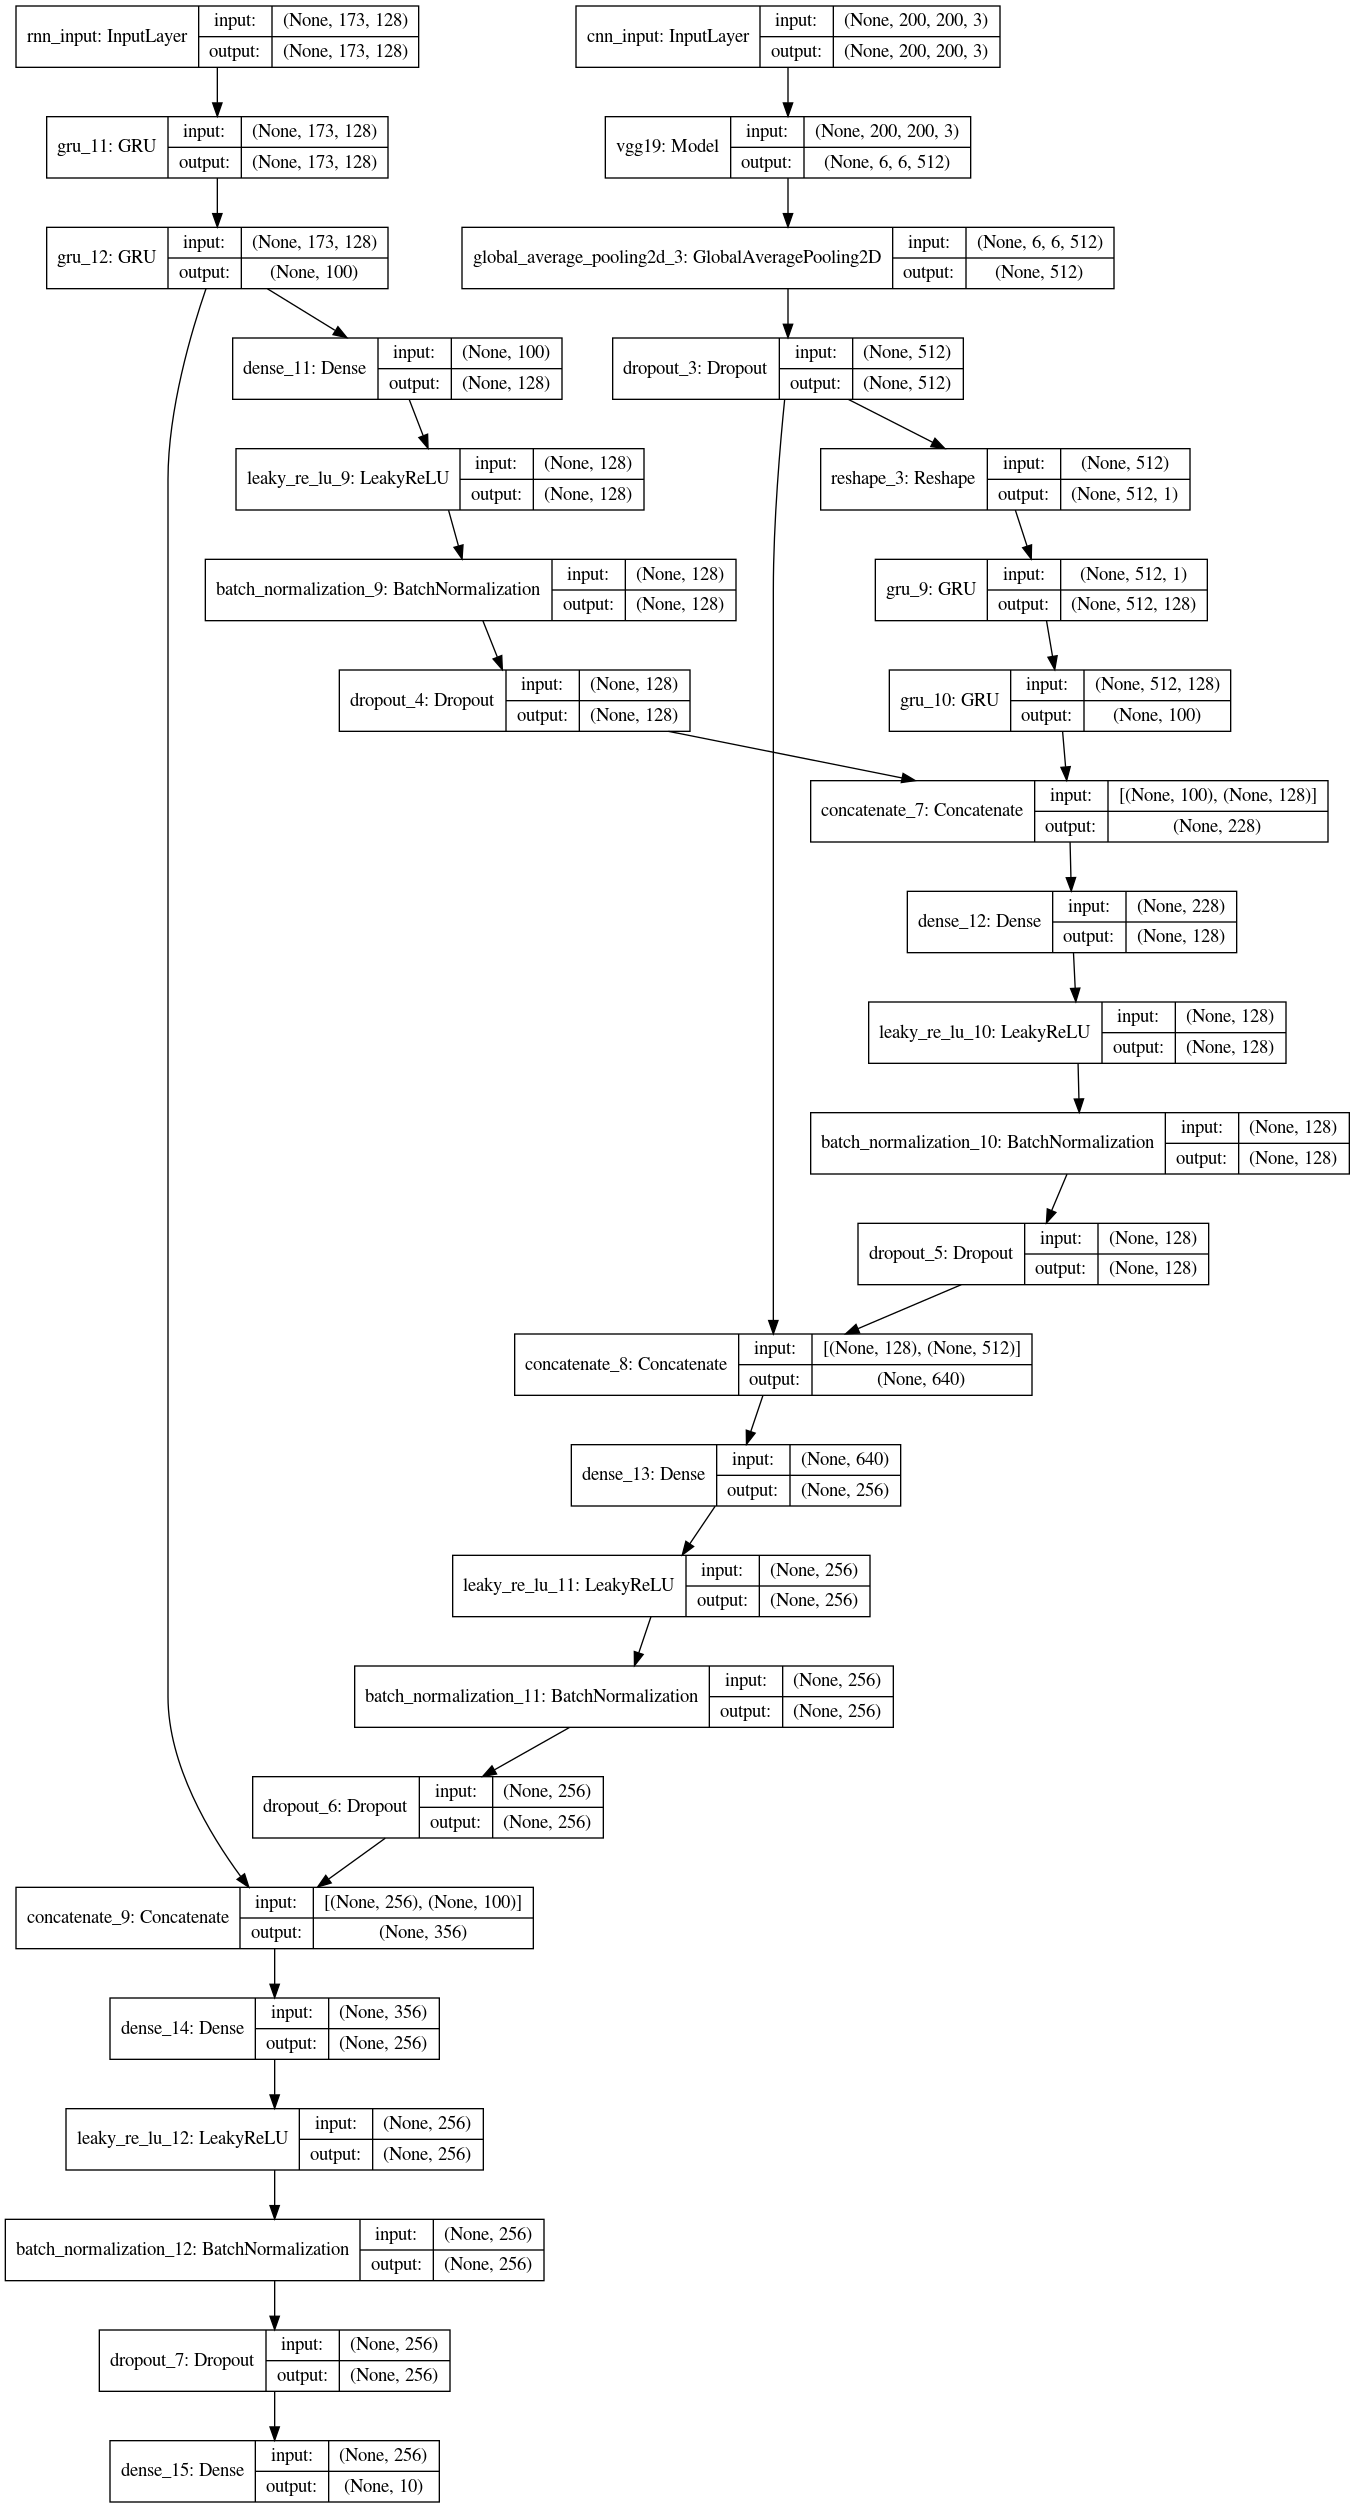

In [19]:
# model = models.load_model('./api_model_I.h5')
model = api_model()
# print layers & model summary
layers = model.layers
for i, layer in enumerate(layers):
    if layer.name=='vgg19':
        layer.trainable = True
        print(f'_{layer.name}: {layer.trainable}')
        for ly in layer.layers:
            if ly.name == 'block5_conv4':
                ly.trainable= True
                print(f'  {ly.name}: {ly.trainable}')
            else:
                ly.trainable=False
                print(f'  {ly.name}: {ly.trainable}')
    else:
        layer.trainable = True
        print(f'_{layer.name}: {layer.trainable}')
        
# model compile
model.compile(
                loss='categorical_crossentropy',
                optimizer= 'Adam',
                metrics = ['acc'],)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
# train model
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.93, verbose=1)]
history = model.fit(
    x= {
        'cnn_input':cnn_x_train,
        'rnn_input':rnn_x_train,
    },
    y= cnn_y_train,
    epochs = 20,
    batch_size= 50,
    validation_data = ([cnn_x_val, rnn_x_val],cnn_y_val),
    callbacks = callbacks,
)

Train on 8000 samples, validate on 1938 samples
Epoch 1/20
8000/8000 [==============================] - 280s 35ms/step - loss: 0.0954 - acc: 0.9674 - val_loss: 0.2600 - val_acc: 0.9329
Epoch 00000: early stopping THR


In [27]:
model.save('./api_model_II.h5')

# VGG Model Tuning II (Unfreeze final block and freeze all dense&rnn layers)

_cnn_input: True
_rnn_input: True
_vgg19: False
  input_1: False
  block1_conv1: False
  block1_conv2: False
  block1_pool: False
  block2_conv1: False
  block2_conv2: False
  block2_pool: False
  block3_conv1: False
  block3_conv2: False
  block3_conv3: False
  block3_conv4: False
  block3_pool: False
  block4_conv1: False
  block4_conv2: False
  block4_conv3: False
  block4_conv4: False
  block4_pool: False
  block5_conv1: False
  block5_conv2: False
  block5_conv3: False
  block5_conv4: False
  block5_pool: False
_gru_11: True
_global_average_pooling2d_3: True
_gru_12: True
_dropout_3: True
_dense_11: True
_reshape_3: True
_leaky_re_lu_9: True
_gru_9: True
_batch_normalization_9: True
_gru_10: True
_dropout_4: True
_concatenate_7: True
_dense_12: True
_leaky_re_lu_10: True
_batch_normalization_10: True
_dropout_5: True
_concatenate_8: True
_dense_13: True
_leaky_re_lu_11: True
_batch_normalization_11: True
_dropout_6: True
_concatenate_9: True
_dense_14: True
_leaky_re_lu_12: True
_

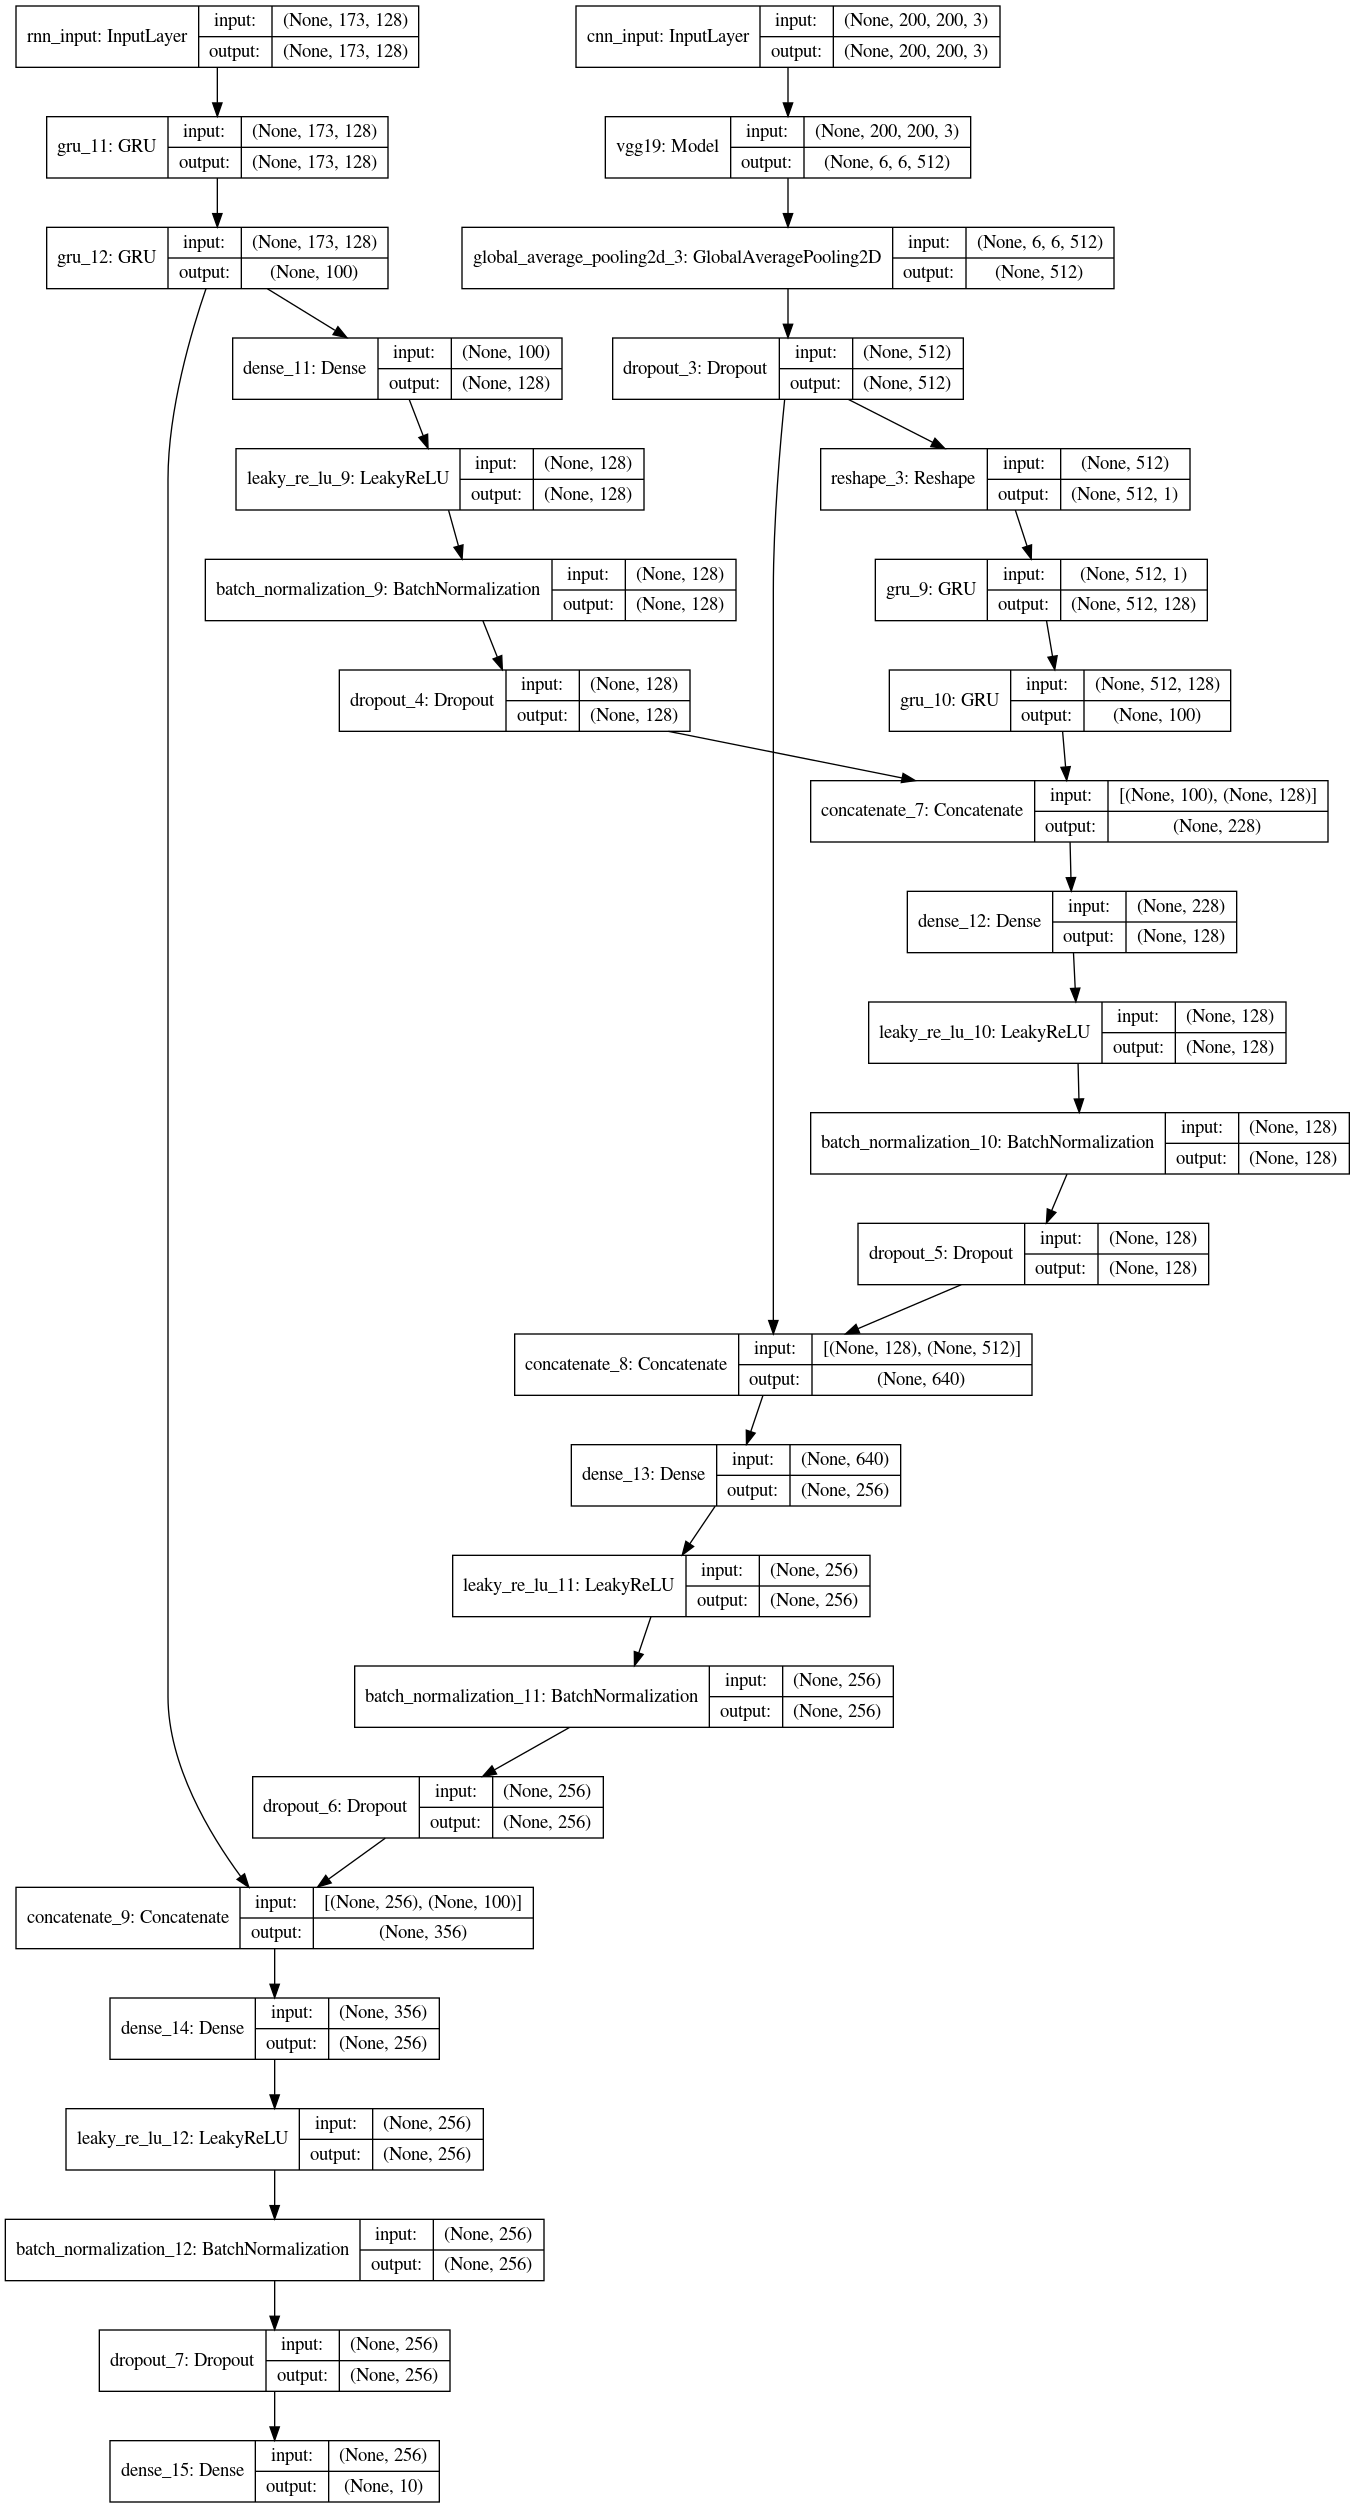

In [4]:
model = models.load_model('./api_model_II.h5')

# print layers & model summary
layers = model.layers
for i, layer in enumerate(layers):
    if layer.name=='vgg19':
        layer.trainable = False
        print(f'_{layer.name}: {layer.trainable}')
        for ly in layer.layers:
            ly.trainable=False
            print(f'  {ly.name}: {ly.trainable}')
    else:
        layer.trainable = True
        print(f'_{layer.name}: {layer.trainable}')

# model compile
model.compile(
                loss='categorical_crossentropy',
                optimizer= 'Adam',
                metrics = ['acc'],)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# train model
callbacks = [EarlyStoppingValAcc(monitor='val_acc', value=0.94, verbose=1)]
history = model.fit(
    x= {
        'cnn_input':cnn_x_train,
        'rnn_input':rnn_x_train,
    },
    y= cnn_y_train,
    epochs = 10,
    batch_size= 50,
    validation_data = ([cnn_x_val, rnn_x_val],cnn_y_val),
    callbacks = callbacks,
)

Train on 8000 samples, validate on 1938 samples
Epoch 1/10
8000/8000 [==============================] - 331s 41ms/step - loss: 0.0891 - acc: 0.9704 - val_loss: 0.2620 - val_acc: 0.9309
Epoch 2/10
8000/8000 [==============================] - 323s 40ms/step - loss: 0.0748 - acc: 0.9740 - val_loss: 0.2828 - val_acc: 0.9272
Epoch 3/10
8000/8000 [==============================] - 321s 40ms/step - loss: 0.0672 - acc: 0.9779 - val_loss: 0.2595 - val_acc: 0.9350
Epoch 4/10
8000/8000 [==============================] - 324s 41ms/step - loss: 0.0649 - acc: 0.9785 - val_loss: 0.2574 - val_acc: 0.9309
Epoch 5/10
8000/8000 [==============================] - 325s 41ms/step - loss: 0.0656 - acc: 0.9772 - val_loss: 0.2728 - val_acc: 0.9278
Epoch 6/10
8000/8000 [==============================] - 325s 41ms/step - loss: 0.0645 - acc: 0.9780 - val_loss: 0.2802 - val_acc: 0.9340
Epoch 7/10
8000/8000 [==============================] - 318s 40ms/step - loss: 0.0560 - acc: 0.9824 - val_loss: 0.2614 - val_acc: 

In [6]:
model.save('./api_model_III.h5')